# load data

In [1]:
pwd

'/mnt/lustre01/pf/g/g260086/Python/SeasonalPred/notebooks'

In [6]:
%matplotlib inline
from netCDF4 import Dataset

import numpy as np
import matplotlib.pyplot as plt
import seaborn

from predictability_utils.utils import helpers, io
from predictability_utils.methods.lrlin_method import run_lrlin
from predictability_utils.methods.cca_method_Copy1 import run_cca

import torch
torch.manual_seed(42)
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
else:
    print("CUDA not available")
    device = torch.device("cpu")
    torch.set_default_tensor_type("torch.FloatTensor")

    
#root_data = '/gpfs/work/nonnenma/data/forecast_predictability/pyrina/'
root_data = '/work/gg0304/g260086/HZG-ML-work/Data'
root_results = '/work/gg0304/g260086/HZG-ML-work/Results'

n_latents = 5
train_months, test_months = [2,3,4], [5,6,7]
train_years = np.arange(0, 46)
test_years = np.arange(71, 111)
n_test_years = len(test_years)
n_bt = 500

# Volumetric soil water layer 1 (EU) ANOMALIES
source_data, _ = io.data_load('swvl1', 'EU', 'anomalies', root_data)

# Temperature at 2m (EU) ANOMALIES
target_data, _ = io.data_load('t2m', 'EU', 'anomalies', root_data)

# training data time stamps and map shape
nc_fn = root_data + "/t2m_ERA20c_monthly_1900-2010.EU.mv.nc"
ts = Dataset(nc_fn, 'r').variables['time'].__array__().data
t2m_eu = Dataset(nc_fn, 'r').variables['t2m'].__array__().data
map_shape = t2m_eu.shape[1:]

#lat lon data
lat = Dataset(nc_fn, 'r').variables['latitude'].__array__().data
lon = Dataset(nc_fn, 'r').variables['longitude'].__array__().data

idcs = helpers.split_train_data(train_months, test_months, train_years, test_years)
idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs

CUDA not available
swvl1.shape (1332, 37, 42)
t2m.shape (1332, 37, 42)


# recreate CCA analysis
- Canonical correlation analysis to identify subspaces $U$, $V$ in source space $X$ and target space $Y$, respectively, such that $(UX)_i$ and $(VY)_i$ are maximally correlated.
- in a second step, establish a (linear) mapping from $VY \approx Q UX$ to predict $VY$ from $UX$.
- predict new $Y$ from $Y \approx V^\dagger Q UX$

calibration period: 1914 - 1959
test period: 1971 - 2010


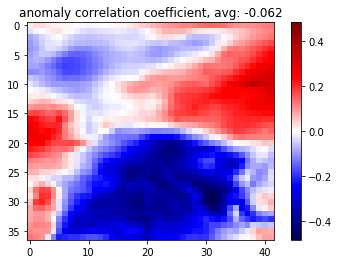

calibration period: 1915 - 1960
test period: 1971 - 2010


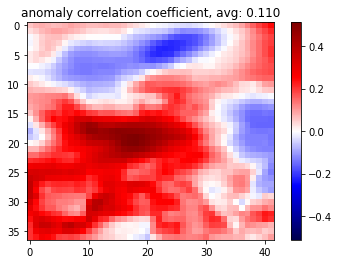

calibration period: 1916 - 1961
test period: 1971 - 2010


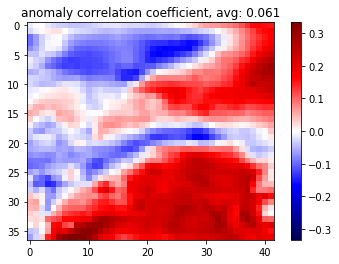

calibration period: 1917 - 1962
test period: 1971 - 2010


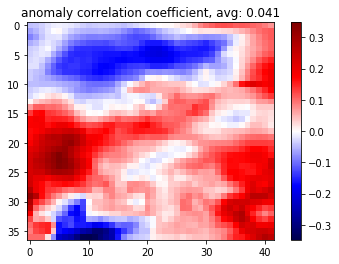

calibration period: 1918 - 1963
test period: 1971 - 2010


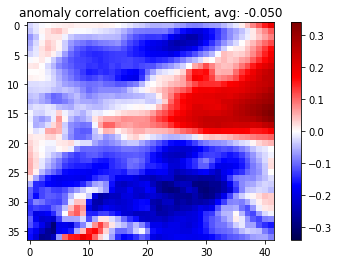

calibration period: 1919 - 1964
test period: 1971 - 2010


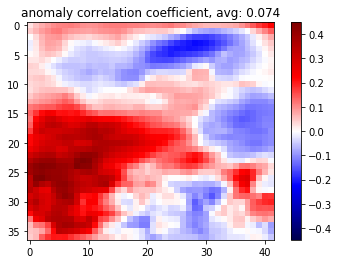

calibration period: 1920 - 1965
test period: 1971 - 2010


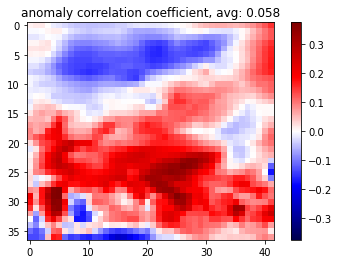

calibration period: 1921 - 1966
test period: 1971 - 2010


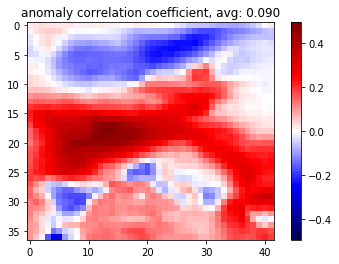

calibration period: 1922 - 1967
test period: 1971 - 2010


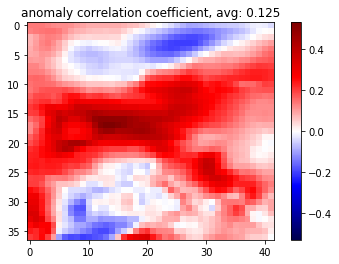

calibration period: 1923 - 1968
test period: 1971 - 2010


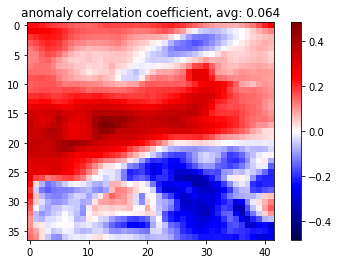

calibration period: 1924 - 1969
test period: 1971 - 2010


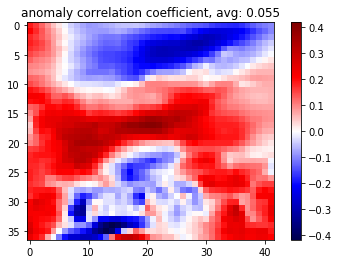

calibration period: 1925 - 1970
test period: 1971 - 2010


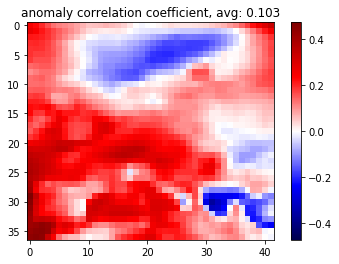

In [8]:
# train an ensemble of models from a sliding window of training years starting in 1914
model_preds, model_targets = [], []
for calibration_offset in range(14,26):
    
    calibration_period = train_years + calibration_offset
    
    print(f'calibration period: {1900+calibration_period[0]} - {1900+calibration_period[-1]}' )
    print(f'test period: {1900+test_years[0]} - {1900+test_years[-1]}' )
    
    idcs = helpers.split_train_data(train_months, test_months, calibration_period, test_years)
    idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs
    
    anomaly_corrs, params = run_cca(source_data, target_data, n_latents, idcs, train_months, test_months, train_years, test_years, if_plot=True, map_shape=map_shape)
    model_preds.append(params['out_pred'])   # grab predictions for later averaging
    model_targets.append(params['out_true']) #

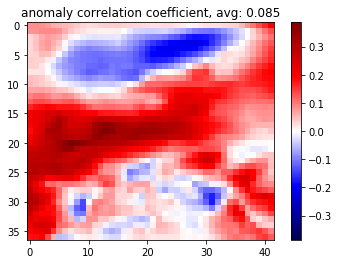

In [9]:
# compute an ensemble-averaged prediction
from predictability_utils.utils import viz

# test sets should be the same
assert np.all( [np.all(out_true==model_targets[0]) for out_true in model_targets] ) 

# average prediction
mean_pred = np.mean(np.stack(model_preds), axis=0)

anomaly_corrs = helpers.compute_anomaly_corrs(model_targets[0], mean_pred)
viz.visualize_anomaly_corrs(anomaly_corrs.reshape(*map_shape)) 

In [10]:
#calculate the significance of the anomaly_corrs with bootstrapping
#build a distribution for each grid point
#the anomaly_corrs found above will be significant if they don't fall in this distribution
import random
corrs_perm = [ ]
pred = mean_pred
orig = model_targets[0]

for _ in range(n_bt):
    pred_perm = np.random.permutation(pred)
    n_corr = helpers.compute_anomaly_corrs(pred_perm,orig)
    corrs_perm.append(n_corr)

print(np.asarray(corrs_perm).shape)

(500, 1554)


In [11]:
#calculate distribution's percentiles
PrecLow = [ ]
PrecUp = [ ]

corr = np.asarray(corrs_perm)
pl = np.percentile(corr, 2.5, axis=0)
pu = np.percentile(corr, 97.5, axis=0)
PrecLow.append(pl)
PrecUp.append(pu)

print(np.asarray(PrecLow).shape); print(np.asarray(PrecUp).shape); 

(1, 1554)
(1, 1554)


In [12]:
lp = np.asarray(PrecLow)
up = np.asarray(PrecUp)
up.shape
#Evaluate if loo_corrs are in the distribution

mask_lp = np.less(anomaly_corrs,lp)
mask_up = np.greater(anomaly_corrs,up)
mask = np.add(mask_lp.astype(int),mask_up.astype(int))
print(mask.reshape(*map_shape).shape)


(37, 42)


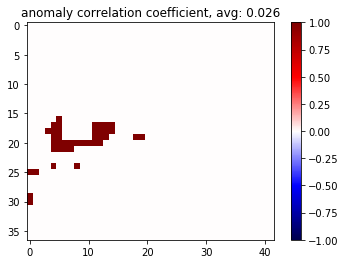

In [13]:
viz.visualize_anomaly_corrs(mask.reshape(*map_shape)) 

In [14]:
print(mean_pred.shape); print(model_targets[0].shape); print(len(model_targets[0]))

(40, 1554)
(40, 1554)
40


In [15]:
#Method: leave-one-out cross-validated correlation (loo-correlation)
#correlate the time series but this time Leaving One year Out

loo_corrs = [ ]
for i in range(0,n_test_years):
    loo_pred = mean_pred[np.arange(len(mean_pred))!=i]
    loo_orig = model_targets[0][np.arange(len(model_targets[0]))!=i]
    
    n_corr = helpers.compute_anomaly_corrs(loo_pred,loo_orig)
    loo_corrs.append(n_corr)
    #print(n_correl.shape); print(loo_pred.shape); print(loo_orig.shape);
print(np.asarray(loo_corrs).shape)

(40, 1554)


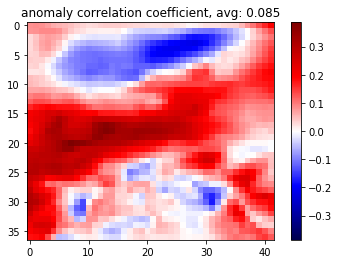

False

In [16]:
loo_corrs_mean = np.mean(np.stack(loo_corrs), axis=0)
viz.visualize_anomaly_corrs(loo_corrs_mean.reshape(*map_shape)) 
np.array_equal(np.asarray(loo_corrs),anomaly_corrs)

In [ ]:
import random
#correlate the permuted time series using loo-correlation
#build a distribution for each grid point
#the correlations loo_corrs will be significant if they don't fall in this distribution
loo_corrs_perm = [ ]
for i in range(0,n_test_years):
    loo_pred = mean_pred[np.arange(len(mean_pred))!=i]
    loo_orig = model_targets[0][np.arange(len(model_targets[0]))!=i]
    for _ in range(n_bt):
        loo_pred_perm = np.random.permutation(loo_pred)
        n_corr = helpers.compute_anomaly_corrs(loo_pred_perm,loo_orig)
        loo_corrs_perm.append(n_corr)
    #print(n_correl.shape); print(loo_pred.shape); print(loo_orig.shape);
print(np.asarray(loo_corrs_perm).shape)
loo_corrs_p = np.asarray(loo_corrs_perm).reshape(n_test_years,n_bt,n_corr.size)
print(loo_corrs_p.shape)

OutFile = root_results + '/Correl_Distribution_weighted_swvl1'
np.save(OutFile,loo_corrs_p)

In [ ]:
loo_corrs_dist = np.load(root_results + '/Correl_Distribution_weighted_swvl1.npy')
loo_corrs_dist.shape

In [ ]:
#calculate the percentiles

loo_PrecLow = [ ]
loo_PrecUp = [ ]

for i in range(0,n_test_years):
    loo_corr = loo_corrs_dist[i,:,:]
    #print(loo_corr.shape); print(loo_corr[0][0]);
    PrecLow = np.percentile(loo_corr, 2.5, axis=0)
    PrecUp = np.percentile(loo_corr, 97.5, axis=0)
    loo_PrecLow.append(PrecLow)
    loo_PrecUp.append(PrecUp)
    
    #print(PrecUp.shape); print(PrecLow.shape); print(PrecUp[0]); print(PrecLow[0])
print(np.asarray(loo_PrecLow).shape); print(np.asarray(loo_PrecUp).shape); 

In [ ]:
loo_corrs_or = np.asarray(loo_corrs)
lp = np.asarray(loo_PrecLow)
up = np.asarray(loo_PrecUp)
up.shape

In [ ]:
#Evaluate if loo_corrs_or are in the distribution
mask_lp = np.zeros(loo_corrs_or.shape)
mask_up = np.zeros(loo_corrs_or.shape)
mask = np.zeros(loo_corrs_or.shape)

for i in range(0,n_test_years):
    
    mask_lp[i,:] = np.less(loo_corrs_or[i,:],lp[i,:])
    mask_up[i,:] = np.greater(loo_corrs_or[i,:],up[i,:])
    mask[i,:] = np.add(mask_lp[i,:],mask_up[i,:])

##show significance only for the regions which were significant in every loo_corrs_or iteration
sign_loo_corrs_prod = np.prod(mask,axis=0)

In [ ]:
viz.visualize_anomaly_corrs(sign_loo_corrs_prod.reshape(*map_shape)) 

In [ ]:
# compare against single model that learns from full training data

calibration_period = np.arange(14, 71)  # training period 1914-1970

idcs = helpers.split_train_data(train_months, test_months, calibration_period, test_years)
idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs
anomaly_corrs, params = run_cca(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape)

In [ ]:
calibration_period = np.arange(14, 70)  # training period 1914-1969

idcs = helpers.split_train_data(train_months, test_months, calibration_period, test_years)
idx_source_train, idx_target_train, idx_source_test, idx_target_test = idcs
anomaly_corrs, params = run_cca(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape)

# simple low-rank linear prediction (pixel MSEs) 

- set up simple model $Y = W X$ with $W = U V$
- low-rank: if $Y \in \mathbb{R}^N, X \in \mathbb{R}^M$, then $W \in \mathbb{R}^{N \times M}$, but $U \in \mathbb{R}^{N \times k}, V \in \mathbb{R}^{k \times M}$ with $k << M,N$ !
- low-rank structure saves us parameters: $M N$ parameters in $W$, but only $N k + k M$ in $U$ and $V$, helps prevent overfitting on low samples size

In [ ]:
anomaly_corrs, params = run_lrlin(source_data, target_data, n_latents, idcs, if_plot=True, map_shape=map_shape,
                                 n_epochs=2000, lr=1e-1, batch_size=None)

# debug